In [3]:
import pygsti
from scipy.linalg import expm
import numpy as np
from pygsti.tools import unitary_to_superop
from pygsti.modelpacks import smq1Q_XYZI
from matplotlib import pyplot as plt
from pygsti.circuits import Circuit
from quapack.pyRPE import RobustPhaseEstimation
from quapack.pyRPE.quantum import Q as _rpeQ
from tqdm import tqdm
from importlib import reload
import kalman_rpe as _krpe
import kalman_filters as _filters

In [4]:
reload(_krpe)
reload(_filters)

<module 'kalman_filters' from '/home/jpmarceaux/VSProjects/KalmanRPE/kalman_filters.py'>

In [5]:
num_trials = 50
gate_depolarization = 0.001
spam_depolarization = 0.001
samples_per_circuit = 100
depths = [2**i for i in range(10)]
error_estimates = []
xerror_trues = []
for _ in tqdm(range(num_trials)):
    xerror_true = 0.1*np.random.rand(3)
    xerror_trues.append(xerror_true)
    error_estimate, error_bound, last_good_gen = _krpe.run_rpe(xerror_true, depths, gate_depolarization, spam_depolarization, samples_per_circuit)
    error_estimates.append(error_estimate)

100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


Text(0.5, 1.0, 'Theta')

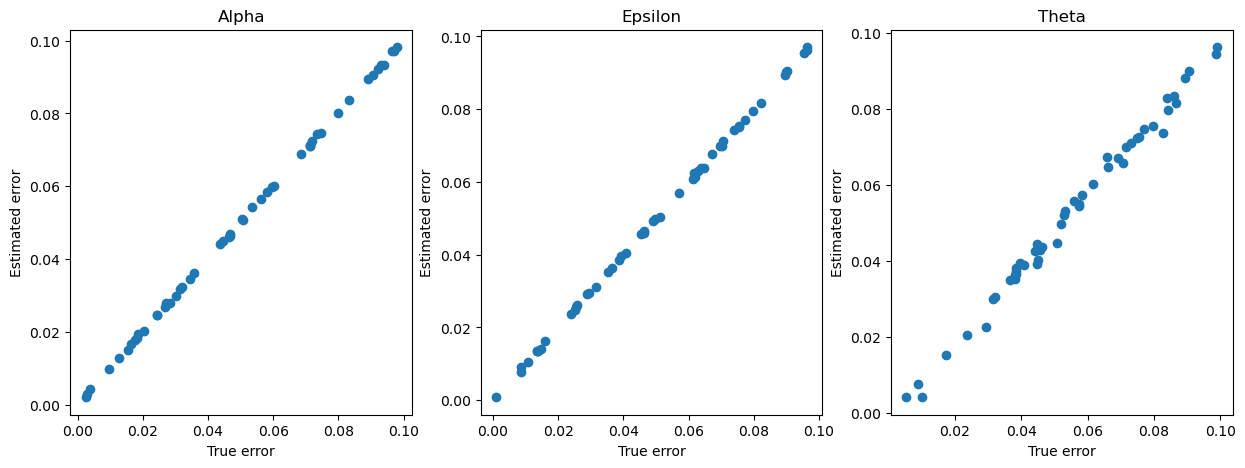

In [6]:
# plot the results
error_estimates = np.array(error_estimates)
xerror_trues = np.array(xerror_trues)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for idx, ax in enumerate(axs):
    ax.scatter(xerror_trues[:, idx], error_estimates[:, idx])
    ax.set_xlabel('True error')
    ax.set_ylabel('Estimated error')
axs[0].set_title('Alpha')
axs[1].set_title('Epsilon')
axs[2].set_title('Theta')

# Experiment 0

proof of concept for Kalman filter

In [7]:
reload(_krpe)
reload(_filters)

<module 'kalman_filters' from '/home/jpmarceaux/VSProjects/KalmanRPE/kalman_filters.py'>

In [8]:
# defining parameters
xtrue = [0.01, 0.01, 0.002]
num_shots = 1000
num_params = 3
num_circs = 6
depths = [1, 2, 4, 8, 16, 32, 64, 128, 512, 1024]

# setting up a filter
Pinitial = 100*np.eye(num_params)
xinitial = np.zeros(3)
print("initial error: ", np.linalg.norm(xtrue - xinitial))
print("initial uncertainty: ", np.sqrt(np.trace(Pinitial)))
ukf = _filters.MyUKF(num_params, num_circs)
ukf.x = xinitial.copy()
ukf.P = Pinitial.copy()
ukf.Q = np.zeros((num_params, num_params))
ekf = _filters.KalmanFilter(xinitial.copy(), Pinitial, save_history=True)
iekf = _filters.KalmanFilter(xinitial.copy(), Pinitial, save_history=True)



initial error:  0.014282856857085701
initial uncertainty:  17.320508075688775


In [9]:
# running an experiment 
for d in depths:
    observation = _krpe.sample_emperical_dist(xtrue, d, num_shots)
    ukf.predict()
    ukf.update(observation, d, num_shots)
    ekf.update(observation, d, num_shots)
    if d == 1:
        iekf.update(observation, d, num_shots)
    else:
        iekf.iterated_update(observation, d, num_shots, tol=1e-4)
print("final ukf error: ", np.linalg.norm(xtrue - ukf.x))
print("final ukf uncertainty: ", np.sqrt(np.trace(ukf.P)))
print("final ekf error: ", np.linalg.norm(xtrue - ekf.x))
print("final ekf uncertainty: ", np.sqrt(np.trace(ekf.P)))
print("final iekf error: ", np.linalg.norm(xtrue - iekf.x))
print("final iekf uncertainty: ", np.sqrt(np.trace(iekf.P)))

final ukf error:  5.590980764779213e-06
final ukf uncertainty:  1.1866377102032629e-05
final ekf error:  5.593379255553949e-06
final ekf uncertainty:  1.1866404972802293e-05
final iekf error:  5.775522722895104e-06
final iekf uncertainty:  1.1866160512259659e-05


# Experiment 1
 A single trial, plotting the estimate at each generation and uncertain compared with RPE and error bound

TODO: add MLE and Cramer-Rao bound

In [10]:
def plot_all_trajectories(xtrue, depths, x_history, P_history, trig_history, trig_error_bound_history, mle_history, cr_bounds, ylim=0.1):
    fig, axs = plt.subplots(3, 1, figsize=(15, 15))
    for idx, ax in enumerate(axs):
        ax.semilogx(depths, np.array(x_history)[:, idx], label='Kalman estimate', color='red')
        ax.semilogx(depths, np.array(trig_history)[:, idx], label='Trig estimate', color='blue')
        ax.semilogx(depths, np.array(mle_history)[:, idx], label='MLE estimate', color='green')
        ax.semilogx(depths, [xtrue[idx]]*len(depths), color='blue', linestyle='dashed')
        ax.set_xlabel('Depth')
        ax.set_ylabel(['Alpha', 'Epsilon', 'Theta'][idx])
        ax.legend()
        ax.set_ylim(xtrue[idx]-ylim, xtrue[idx]+ylim)
        # make inset that is a zoom in on the last few depths
        axins = ax.inset_axes([0.1, 0.1, 0.3, 0.3])
        inset_size = 3
        axins.semilogx(depths[-inset_size:], np.array(x_history)[-inset_size:, idx], label='Kalman estimate', color='red')
        axins.semilogx(depths[-inset_size:], np.array(trig_history)[-inset_size:, idx], label='Trig estimate', color='blue')
        axins.semilogx(depths[-inset_size:], np.array(mle_history)[-inset_size:, idx], label='MLE estimate', color='green')
        axins.semilogx(depths[-inset_size:], [xtrue[idx]]*inset_size, color='blue', linestyle='dashed', label='True value')
        # plot the kalman error bounds in the inset
        axins.fill_between(depths[-inset_size:], np.array(x_history)[-inset_size:, idx] - 2*np.sqrt(np.array(P_history)[-inset_size:, idx, idx]), np.array(x_history)[-inset_size:, idx] + 2*np.sqrt(np.array(P_history)[-inset_size:, idx, idx]), alpha=0.5, color='red')
        
        axins.set_xlabel('Depth')
        axins.set_ylabel(['Alpha', 'Epsilon', 'Theta'][idx])
        axins.legend()
        ax.indicate_inset_zoom(axins)

        # make the covariance bounds from the UKF, where the bounds are the square root of the diagonal of the covariance matrix
        ax.fill_between(depths, np.array(x_history)[:, idx] - 2*np.sqrt(np.array(P_history)[:, idx, idx]), np.array(x_history)[:, idx] + 2*np.sqrt(np.array(P_history)[:, idx, idx]), alpha=0.5, color='red')
        # do the cr bounds wrt the mle estimate
        ax.fill_between(depths, np.array(mle_history)[:, idx] - cr_bounds[:, idx], np.array(mle_history)[:, idx] + cr_bounds[:, idx], alpha=0.5, color='green')        
        
    # set title of the whole plot
    axs[0].set_title('Trajectories, no depolarization')
    axs[0].fill_between(depths, np.array(trig_history)[:, 0] - np.array(trig_error_bound_history)[:, 0], np.array(trig_history)[:, 0] + np.array(trig_error_bound_history)[:, 0], alpha=0.5, color='blue')
    axs[1].fill_between(depths, np.array(trig_history)[:, 1] - np.array(trig_error_bound_history)[:, 0], np.array(trig_history)[:, 1] + np.array(trig_error_bound_history)[:, 0], alpha=0.5, color='blue')
    axs[2].fill_between(depths, np.array(trig_history)[:, 2] - np.array(trig_error_bound_history)[:, 1], np.array(trig_history)[:, 2] + np.array(trig_error_bound_history)[:, 1], alpha=0.5, color='blue')
    

In [11]:
reload(_filters)

<module 'kalman_filters' from '/home/jpmarceaux/VSProjects/KalmanRPE/kalman_filters.py'>

In [12]:
xtrue

[0.01, 0.01, 0.002]

In [13]:
iekf.x

array([0.00999983, 0.01000546, 0.00200188])

In [14]:
# defining parameters
num_shots = 1000
num_params = 3
num_circs = 6
depths = [1, 2, 4, 8, 16, 32, 64, 128, 512, 1024]
# ukf = MyUKF(num_params, num_circs, depths)
# observations = sample_observation_probabilities(xtrue, 1, num_shots)
# ukf.predict()
# ukf.update(observations, 1, num_shots)

In [15]:
reload(_krpe)
reload(_filters)

<module 'kalman_filters' from '/home/jpmarceaux/VSProjects/KalmanRPE/kalman_filters.py'>

In [16]:
# running an experiment
Pinitial = 4*np.pi*np.eye(num_params)
xinitial = np.zeros(3)
xtrue = [0.01, 0.01, 0.002]
xhistory = [xinitial]
Phistory = [Pinitial]

trig_history = [xinitial]
trig_error_bound_history = [np.array([np.pi, np.pi, np.pi])]
last_good_gen_history = [0]

dataset = _krpe.simulate_rpe_experiment(xtrue, depths, 0.000, 0.000, num_shots)

# make a new trig estimate for each depth
for idx in tqdm(range(len(depths))):
    trig_estimate, trig_error_bound, last_good_gen = _krpe.make_rpe_estimate(dataset, depths[:idx+1])
    trig_history.append(trig_estimate)
    trig_error_bound_history.append(trig_error_bound)
    last_good_gen_history.append(last_good_gen)

# setting up a filter
ukf = _filters.MyUKF(num_params, num_circs)
ukf.x = xinitial
ukf.P = Pinitial
ukf.Q = np.zeros((num_params, num_params))
xhistory, Phistory = ukf.update_from_dataset(dataset, depths, num_shots, save_history=True)
xhistory.append(ukf.x)
Phistory.append(ukf.P)


xhistory = np.array(xhistory)
Phistory = np.array(Phistory)
trig_history = np.array(trig_history)
trig_error_bound_history = np.array(trig_error_bound_history)
last_good_gen_history = np.array(last_good_gen_history)


100%|██████████| 10/10 [00:00<00:00, 37.83it/s]


In [17]:
mle_estimate, mle_history = _krpe.make_mle_estimate(xtrue, dataset, depths, gate_depolarization, spam_depolarization, show_progress=True)

100%|██████████| 10/10 [00:32<00:00,  3.22s/it]


In [18]:
all_cr_bounds = [[1, 1, 1]] + [_krpe.make_cr_bounds(xtrue, dataset, _krpe.make_rpe_circuits(depths[:i+1]), 0.000, 0.000) for i in range(len(depths))]
cr_bounds = np.array(all_cr_bounds)

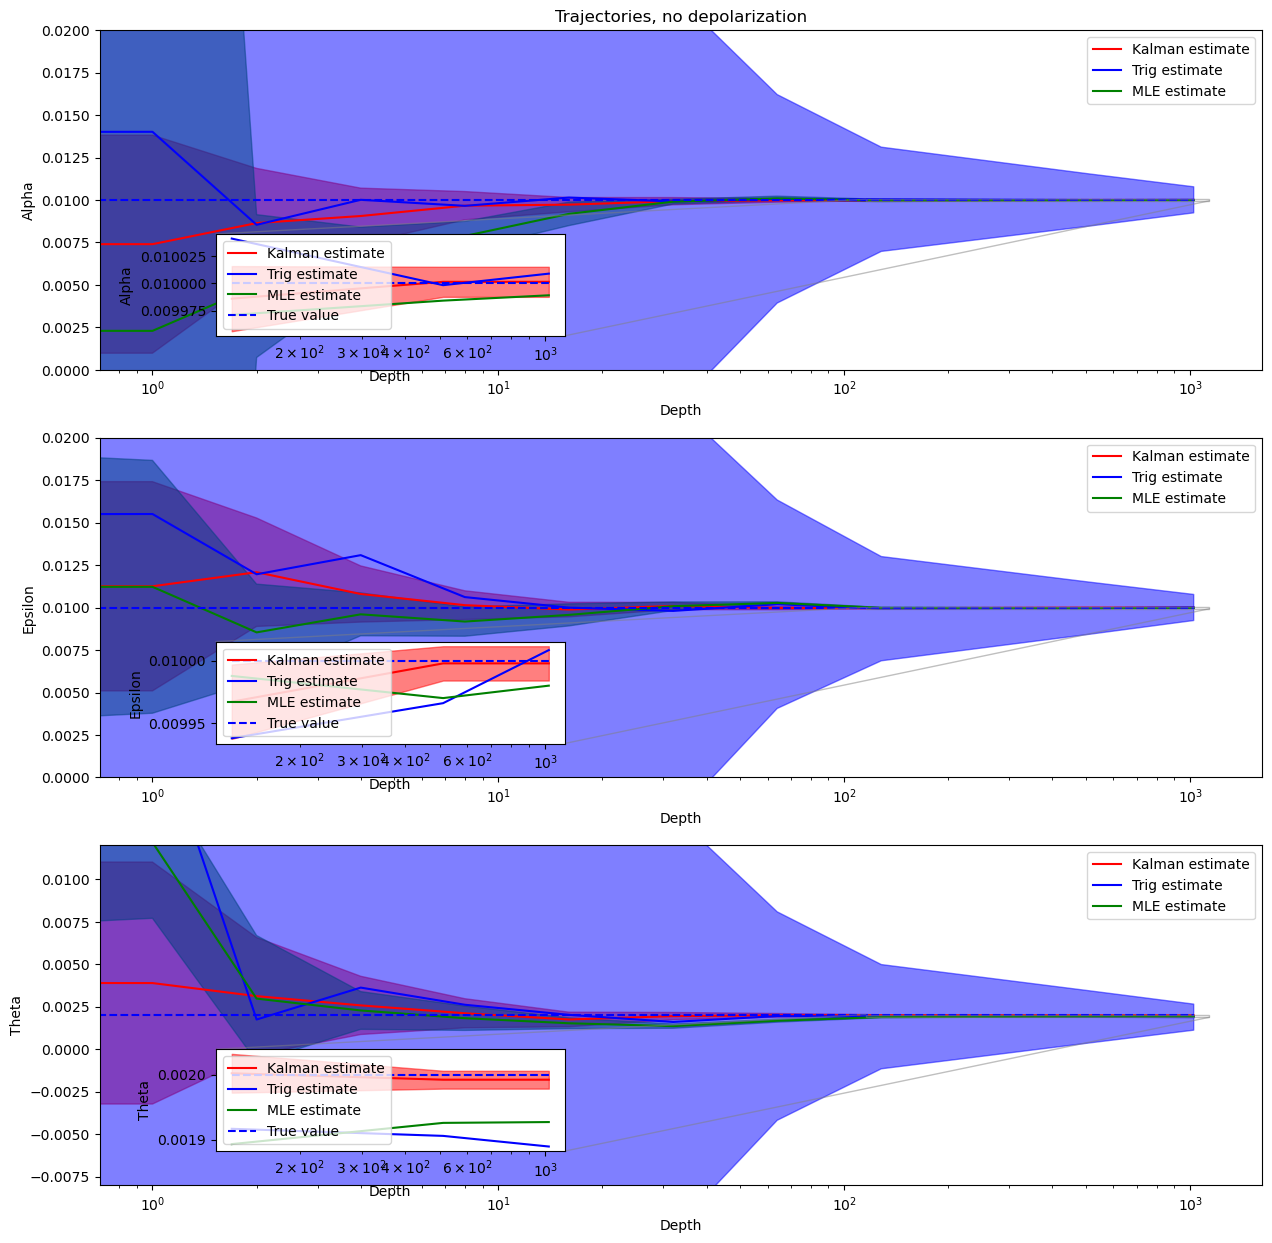

In [19]:
plot_all_trajectories(xtrue, [0]+depths, xhistory, Phistory, trig_history, trig_error_bound_history, mle_history, cr_bounds, 0.01)

# Experiment 2

Many random trials, compared with Trig inversion and MLE 

In [20]:
# compare over many random trials
num_trials = 100
gate_depolarization = 0.001
spam_depolarization = 0.01
samples_per_circuit = 1000
depths = [2**i for i in range(8)]
rpe_error_estimates = []
rpe_error_bounds = []
rpe_last_good_gens = []
kalman_error_estimates = []
kalman_covar_estimates = []
mle_error_estimates = []
mle_error_bounds = []
xerror_trues = []

P = 0.001*np.eye(3)
xinitial = np.zeros(3)

include_mle = False

for _ in tqdm(range(num_trials)):
    xerror_true = np.random.multivariate_normal(xinitial, P)
    dataset = _krpe.simulate_rpe_experiment(xerror_true, depths, gate_depolarization, spam_depolarization, samples_per_circuit)
    xerror_trues.append(xerror_true)
    estimate, bound, last_good_gen = _krpe.make_rpe_estimate(dataset, depths)
    rpe_error_bounds.append(bound)
    rpe_error_estimates.append(estimate)
    rpe_last_good_gens.append(last_good_gen)
    if include_mle:
        mle_estimate, mle_history = _krpe.make_mle_estimate(xerror_true, dataset, depths)
        mle_error_estimates.append(mle_estimate)
        fmat = _krpe.make_fisher_info_matrix(xerror_true, dataset, _krpe.make_rpe_circuits(depths), gate_depolarization, spam_depolarization)
        cr_bounds = _krpe.make_cr_bounds(fmat)
        mle_error_bounds.append(cr_bounds)
    ukf = _filters.MyUKF(3, 6)
    ukf.x = xinitial
    ukf.P = P
    ukf.Q = np.zeros((3, 3))
    ukf.update_from_dataset(dataset, depths, samples_per_circuit, save_history=False)
    kalman_error_estimates.append(ukf.x)
    kalman_covar_estimates.append(ukf.P)

100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


In [21]:
def plot_histogram(true_values, trig_estimate, kalman_estimate, mle_estimate):
    """Plot histogram of the MSE in the final estimates compared to the true values. for each parameter and the total"""
    trig_rmse = np.sqrt(np.mean((np.array(trig_estimate) - np.array(true_values))**2, axis=1))
    kalman_rmse = np.sqrt(np.mean((np.array(kalman_estimate) - np.array(true_values))**2, axis=1))
    if mle_estimate:
        mle_rmse = np.sqrt(np.mean((np.array(mle_estimate) - np.array(true_values))**2, axis=1))
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    bins = np.linspace(0, max(trig_rmse), 100)
    ax.hist(trig_rmse, bins=bins, alpha=0.5, label='Trig estimate')
    ax.hist(kalman_rmse, bins=bins, alpha=0.5, label='Kalman estimate')
    if mle_estimate:
        ax.hist(mle_rmse, bins=20, alpha=0.5, label='MLE estimate')
    ax.legend()
    ax.set_xlabel('RMSE')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Many trials with random parameters gate depol. = {gate_depolarization}, spam depolarization = spam depol. = {spam_depolarization}')

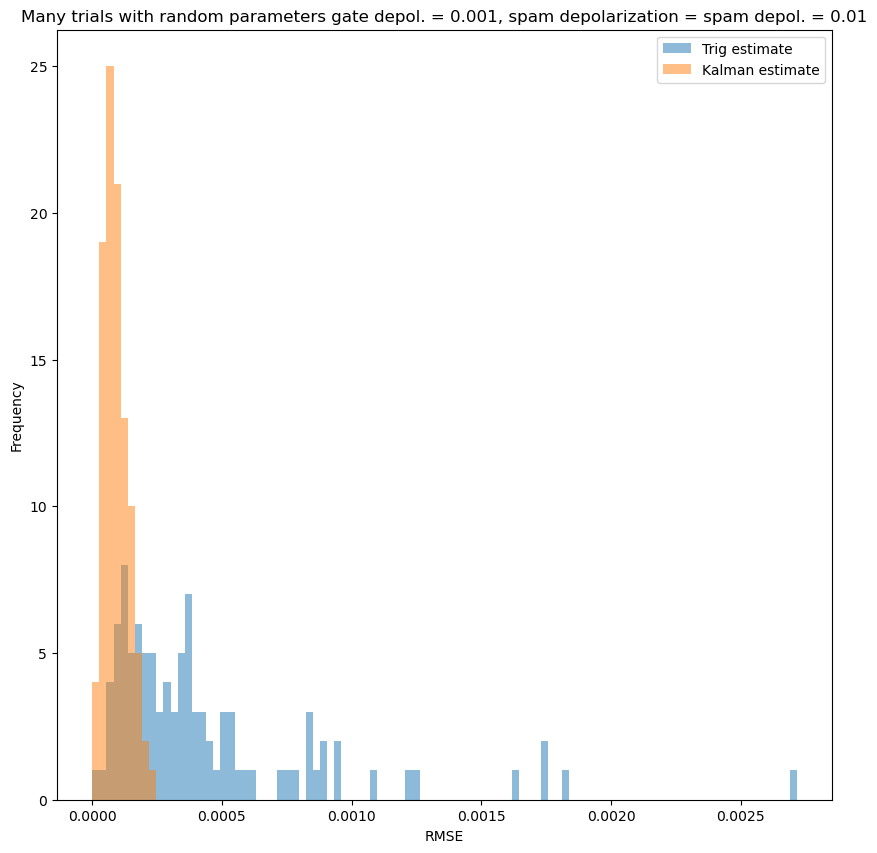

In [22]:
plot_histogram(xerror_trues, rpe_error_estimates, kalman_error_estimates, mle_error_estimates)

# Experiment 3

A single experiment with many different datasets


In [100]:
# compare over single state, many datasets
num_datasets = 100
gate_depolarization = 0.001
spam_depolarization = 0.01
samples_per_circuit = 1000
depths = [2**i for i in range(10)]

bootstrapped_trig_estimates = []
bootstrapped_trig_bounds = []
bootstrapped_ukf_estimates = []
bootstrapped_ukf_covars = []

P = 0.01*np.eye(3)
xinitial = np.zeros(3)
xerror_true = np.random.multivariate_normal(xinitial, P)


for _ in tqdm(range(num_datasets)):
    dataset = _krpe.simulate_rpe_experiment(xerror_true, depths, gate_depolarization, spam_depolarization, samples_per_circuit)
    trig_estimate_per_dataset = []
    trig_bound_per_dataset = []
    
    for idx, d in enumerate(depths):
        estimate, bound, last_good_gen = _krpe.make_rpe_estimate(dataset, depths[:idx+1])
        trig_estimate_per_dataset.append(estimate)
        trig_bound_per_dataset.append(bound)
    
    bootstrapped_trig_estimates.append(trig_estimate_per_dataset)
    bootstrapped_trig_bounds.append(trig_bound_per_dataset)

    # if include_mle:
    #     mle_estimate, mle_history = _krpe.make_mle_estimate(xerror_true, dataset, depths)
    #     mle_error_estimates.append(mle_estimate)
    #     fmat = _krpe.make_fisher_info_matrix(xerror_true, dataset, _krpe.make_rpe_circuits(depths), gate_depolarization, spam_depolarization)
    #     cr_bounds = _krpe.make_cr_bounds(fmat)
    #     mle_error_bounds.append(cr_bounds)

    ukf = _filters.MyUKF(3, 6)
    ukf.x = xinitial
    ukf.P = P
    ukf.Q = np.zeros((3, 3))
    xhistory, Phistory = ukf.update_from_dataset(dataset, depths, samples_per_circuit, save_history=True)
    bootstrapped_ukf_estimates.append(xhistory)
    bootstrapped_ukf_covars.append(Phistory)
    

100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


In [101]:
bootstrapped_trig_bounds = np.array(bootstrapped_trig_bounds)
bootstrapped_trig_estimates = np.array(bootstrapped_trig_estimates)
bootstrapped_ukf_covars = np.array(bootstrapped_ukf_covars)
bootstrapped_ukf_estimates = np.array(bootstrapped_ukf_estimates)

In [102]:
def plot_final_bootstrapped_distribution_at_depth(depth_idx, xtrue, bootstrapped_trig_estimates, bootstrapped_kalman_estimates):
    """Plot histogram of the SE in the final estimates compared to the true values for each of the parameters."""
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    trig_estimate_at_depth = bootstrapped_trig_estimates[:, depth_idx]
    kalman_estimate_at_depth = bootstrapped_kalman_estimates[:, depth_idx]
    for idx, ax in enumerate(axs):
        kalman_error = kalman_estimate_at_depth[:, idx] - xtrue[idx]
        # ax.hist(trig_se, alpha=0.5, label='Trig estimate')
        ax.hist(kalman_error, alpha=0.5, label='Kalman estimate')
        ax.hist(trig_estimate_at_depth[:, idx] - xtrue[idx], alpha=0.5, label='Trig estimate')
        ax.legend()
    axs[0].set_title('Alpha')
    axs[1].set_title('Epsilon')
    axs[2].set_title('Theta')
    # set title of the whole plot
    fig.suptitle('Bootstrapped distribution of error in final estimates')
        
        

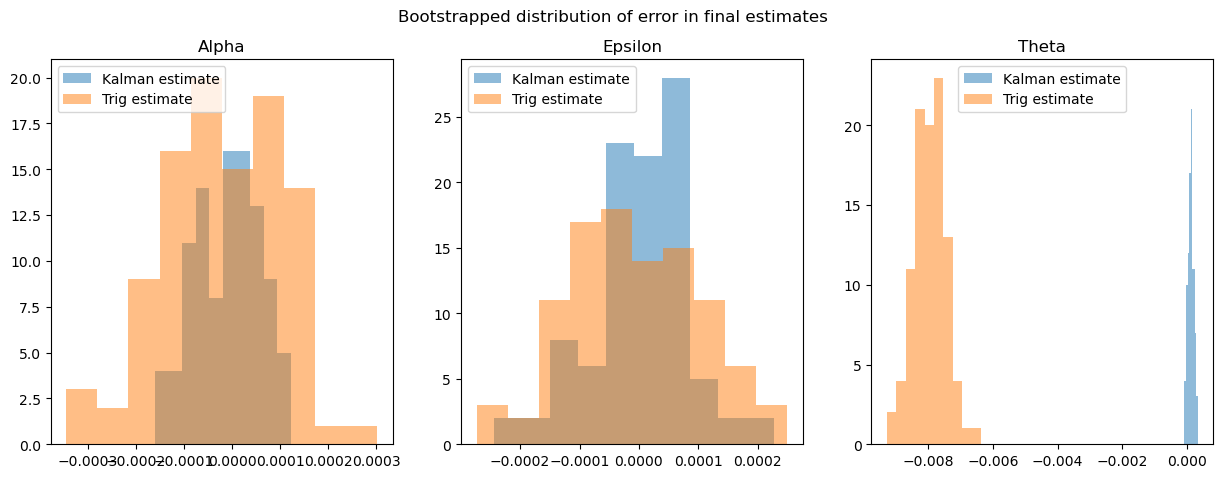

In [103]:
plot_final_bootstrapped_distribution_at_depth(-1, xerror_true, bootstrapped_trig_estimates, bootstrapped_ukf_estimates)

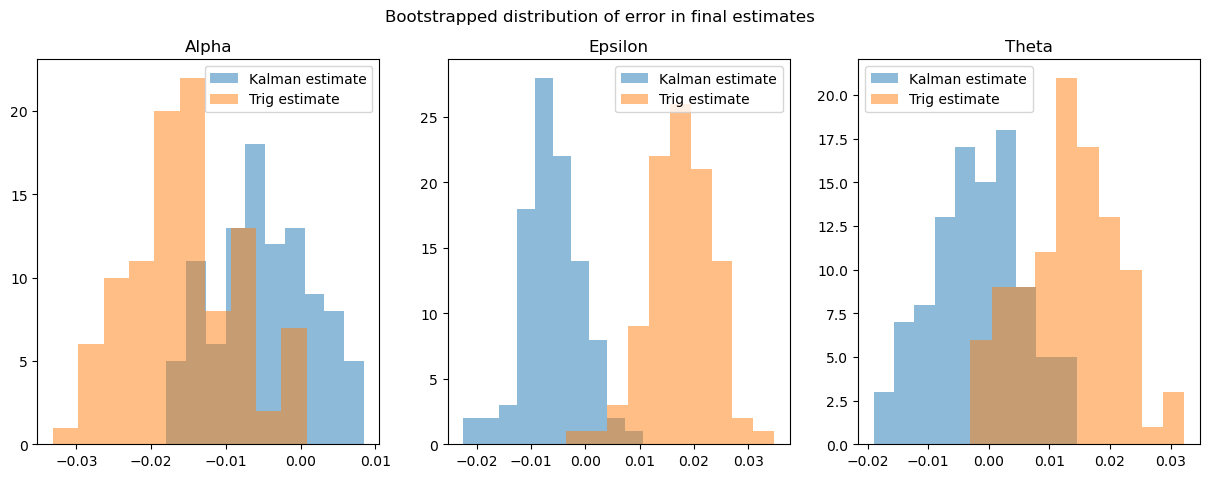

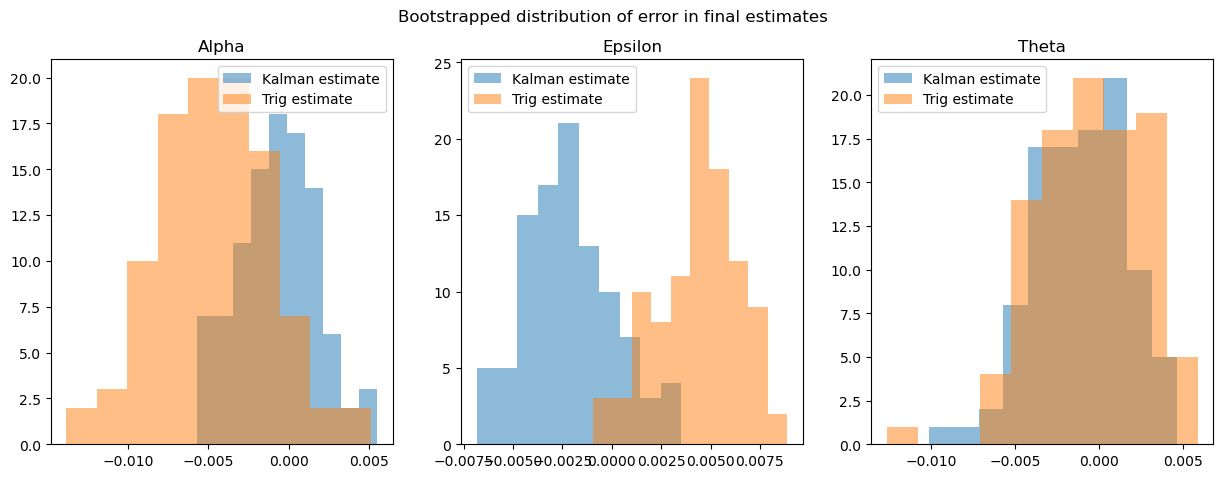

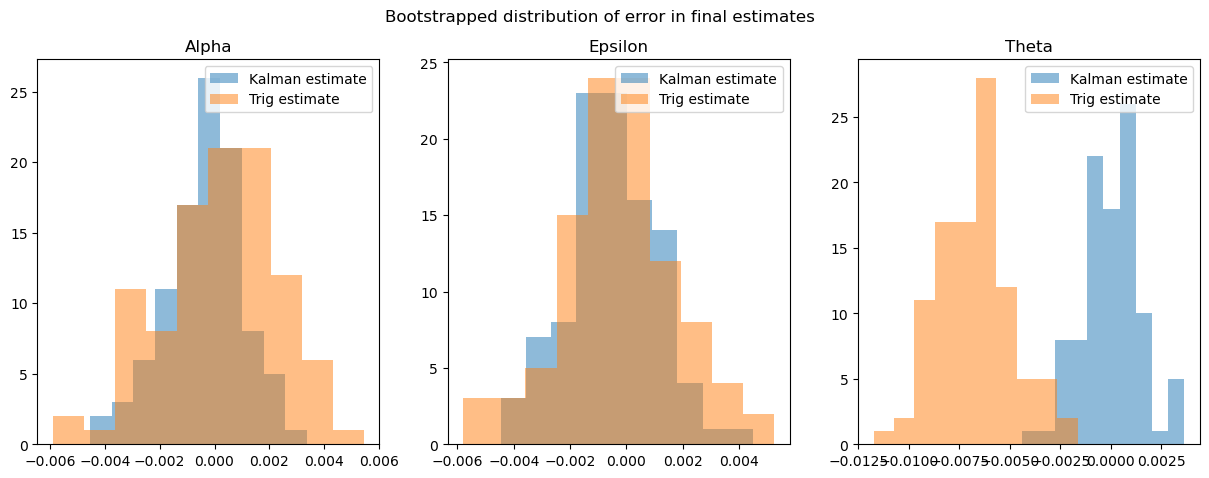

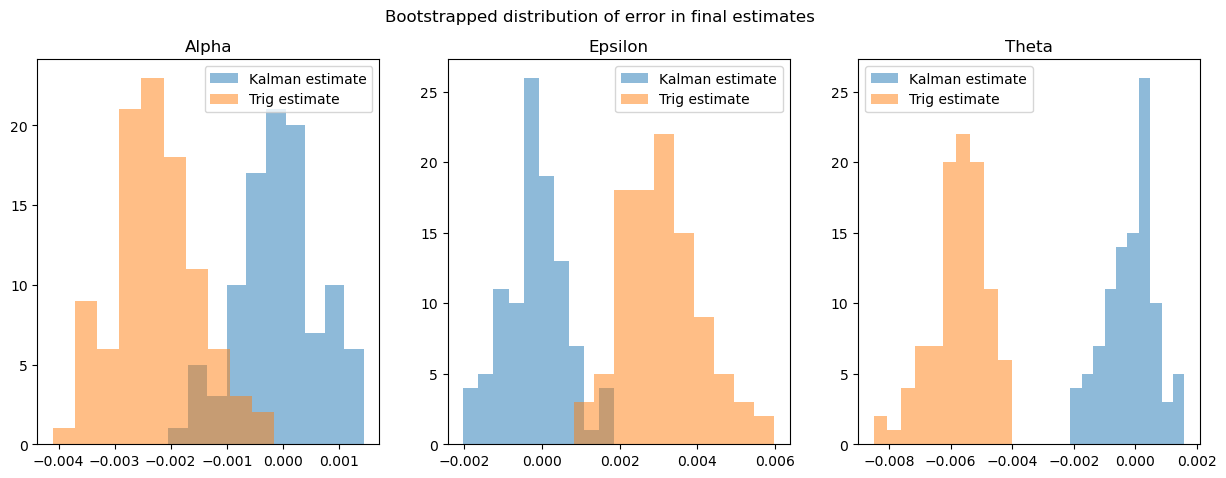

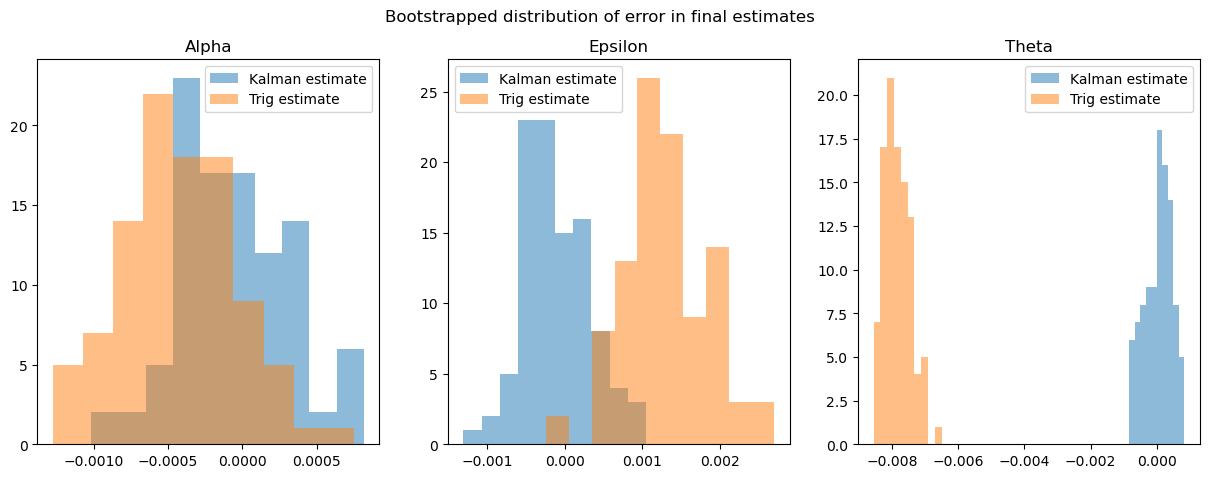

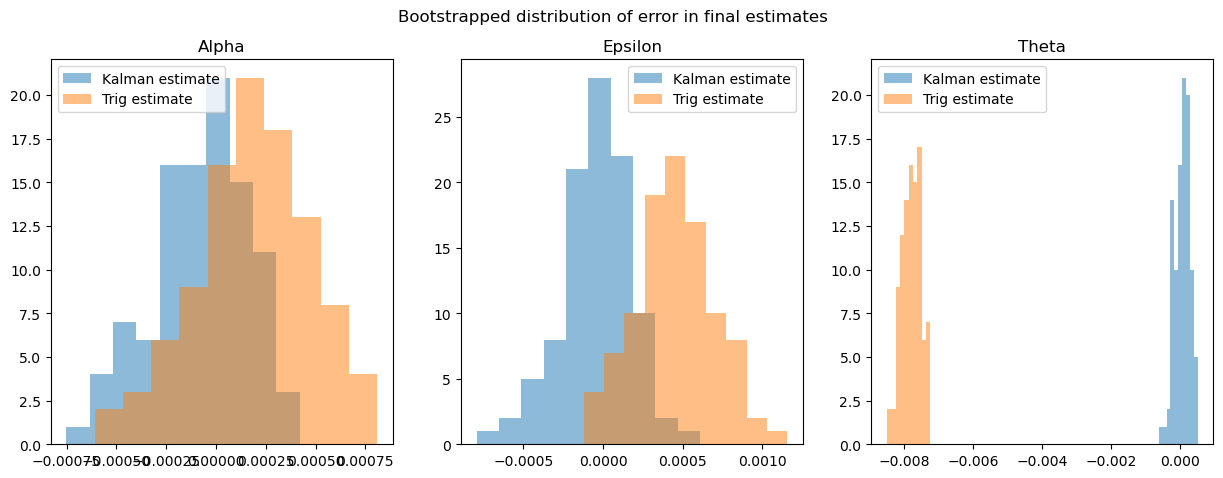

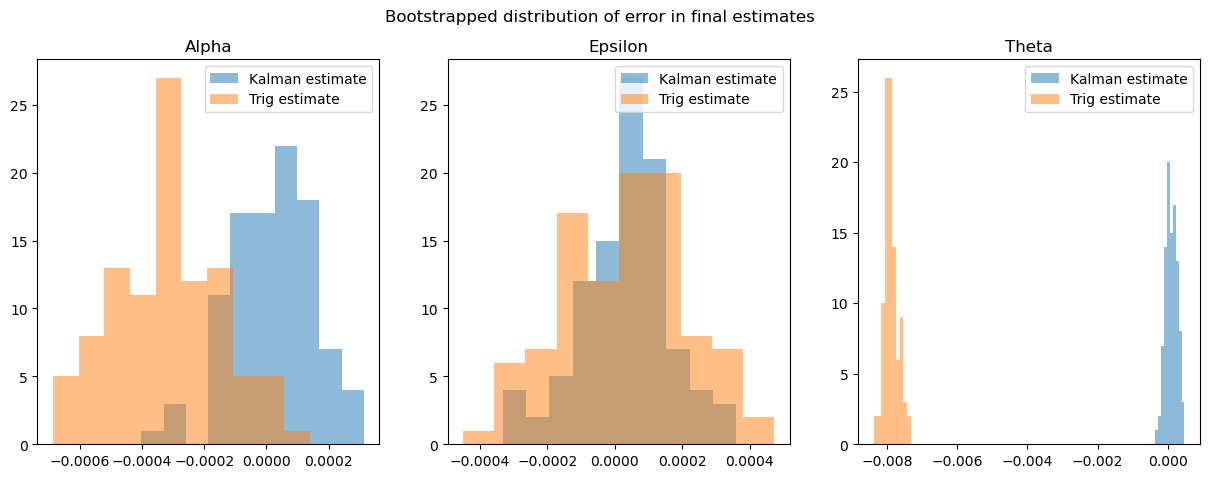

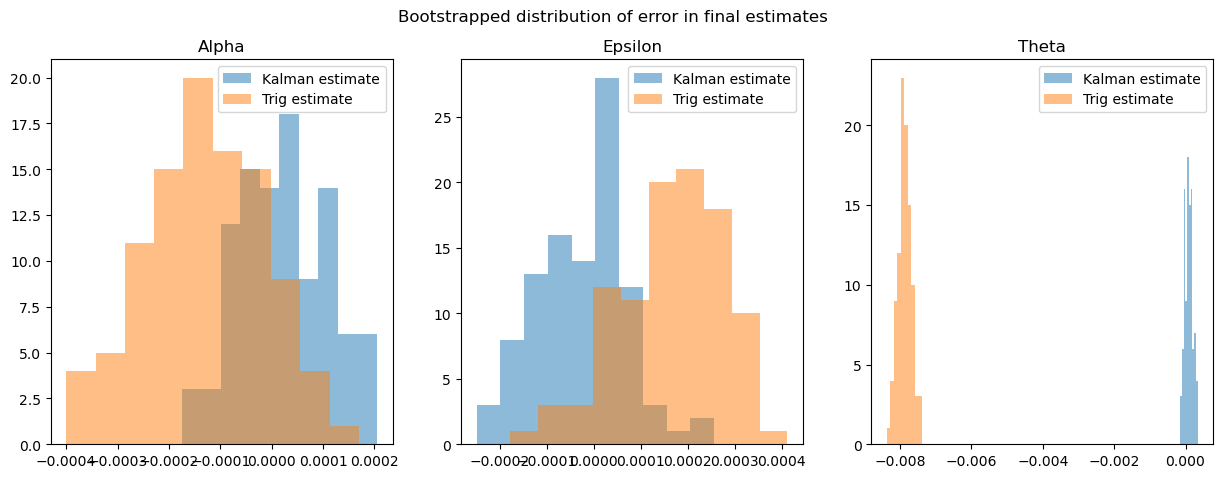

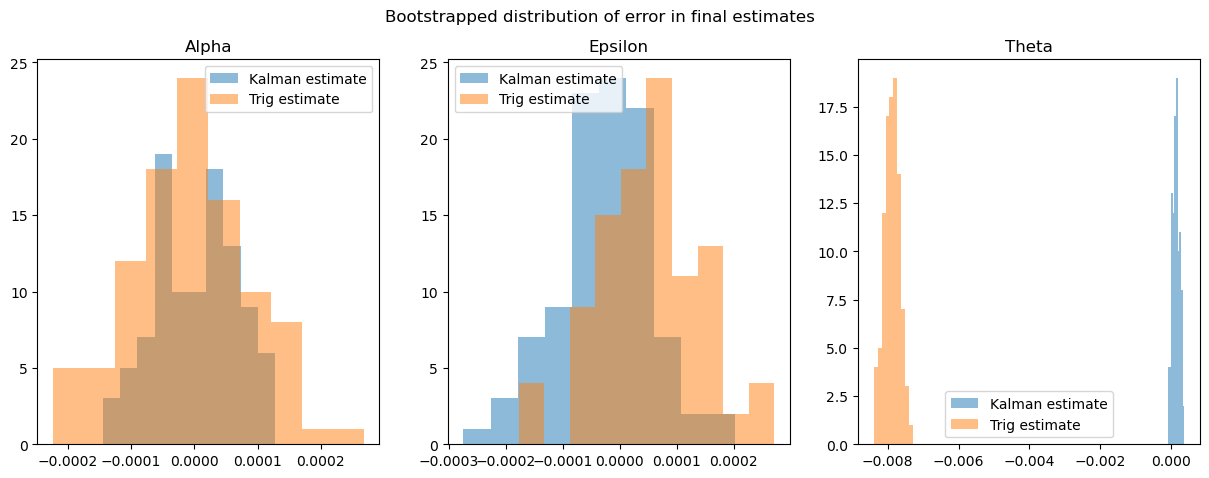

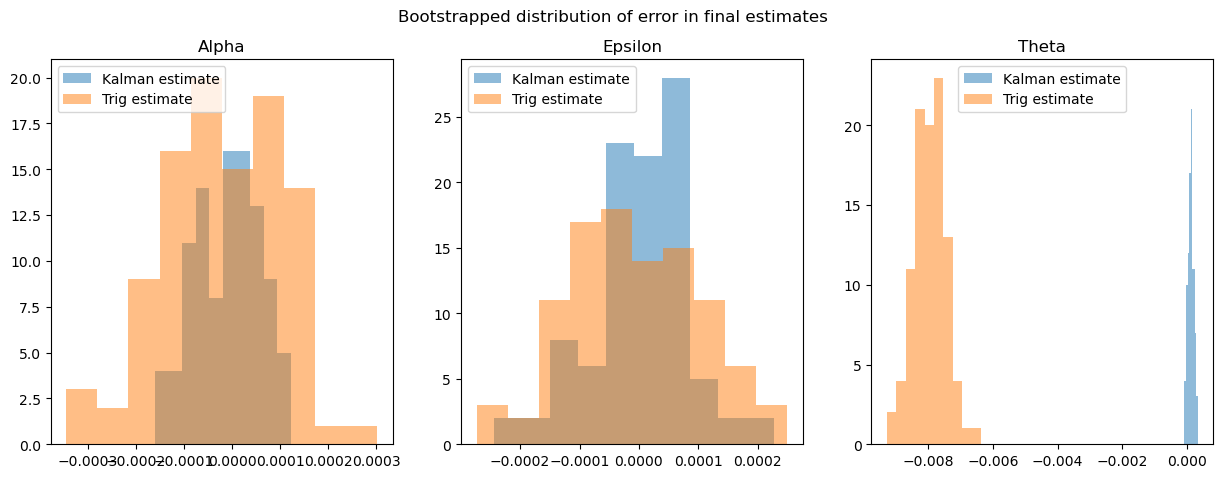

In [104]:
# plot the bootstrapped distribution for all the depths
for idx, d in enumerate(depths):
    plot_final_bootstrapped_distribution_at_depth(idx, xerror_true, bootstrapped_trig_estimates, bootstrapped_ukf_estimates)

In [105]:
def calculate_bootstrapped_variance(bootstrapped_estimates, true_values):
    """Calculate the variance of the bootstrapped estimates."""
    return np.mean((bootstrapped_estimates - true_values)**2, axis=0)

def calculate_bootstrapped_bias(bootstrapped_estimates, true_values):
    """Calculate the bias of the bootstrapped estimates."""
    return np.mean(bootstrapped_estimates - true_values, axis=0)

In [106]:
for idx, d in enumerate(depths):
    print(f"Depth {d}")
    print("Trig variance: ", calculate_bootstrapped_variance(bootstrapped_trig_estimates[:, idx], xerror_true))
    print("Trig bias: ", calculate_bootstrapped_bias(bootstrapped_trig_estimates[:, idx], xerror_true))
    print("UKF variance: ", calculate_bootstrapped_variance(bootstrapped_ukf_estimates[:, idx], xerror_true))
    print("UKF bias: ", calculate_bootstrapped_bias(bootstrapped_ukf_estimates[:, idx], xerror_true))

Depth 1
Trig variance:  [0.00029583 0.00034199 0.00023202]
Trig bias:  [-0.01560513  0.01746247  0.01316957]
UKF variance:  [6.53657995e-05 6.43395928e-05 6.05754539e-05]
UKF bias:  [-0.0049894  -0.0060313  -0.00188636]
Depth 2
Trig variance:  [3.41404249e-05 2.33357575e-05 1.01574118e-05]
Trig bias:  [-0.00469166  0.00436954 -0.00043667]
UKF variance:  [6.44760132e-06 9.95602857e-06 8.68278704e-06]
UKF bias:  [-0.00066251 -0.00217886 -0.00109622]
Depth 4
Trig variance:  [4.44616239e-06 4.08085053e-06 4.95655632e-05]
Trig bias:  [ 0.00018386 -0.00026113 -0.00679014]
UKF variance:  [2.17209892e-06 2.80422917e-06 2.09158699e-06]
UKF bias:  [-3.59981140e-04 -4.50392255e-04 -2.55030790e-05]
Depth 8
Trig variance:  [5.63828221e-06 1.04495238e-05 3.37334749e-05]
Trig bias:  [-0.00224913  0.00306942 -0.00574305]
UKF variance:  [5.28217423e-07 6.47935043e-07 6.70434972e-07]
UKF bias:  [-5.02858325e-05 -1.88430640e-04 -1.41863491e-04]
Depth 16
Trig variance:  [3.20412832e-07 1.96558558e-06 6.13

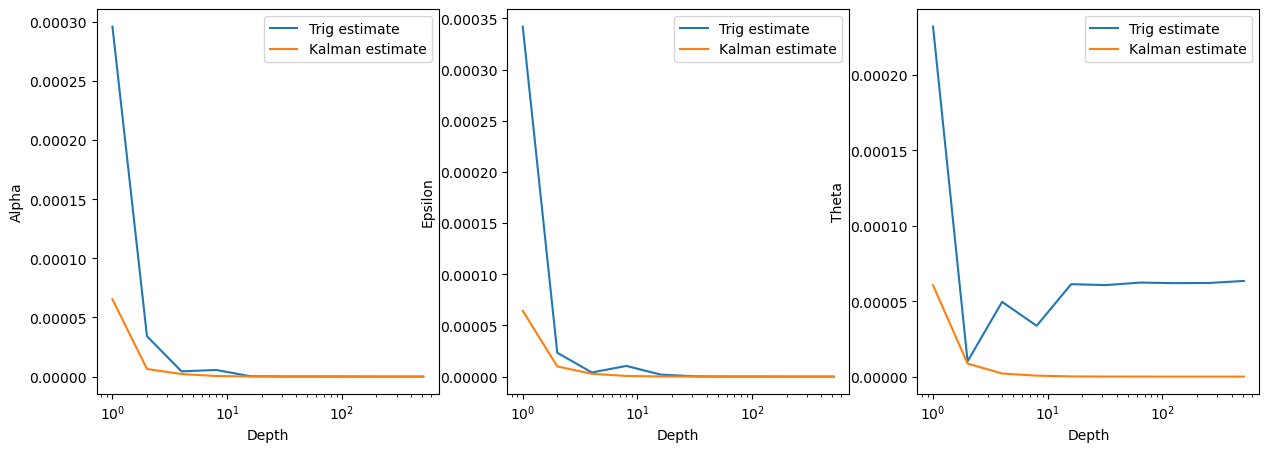

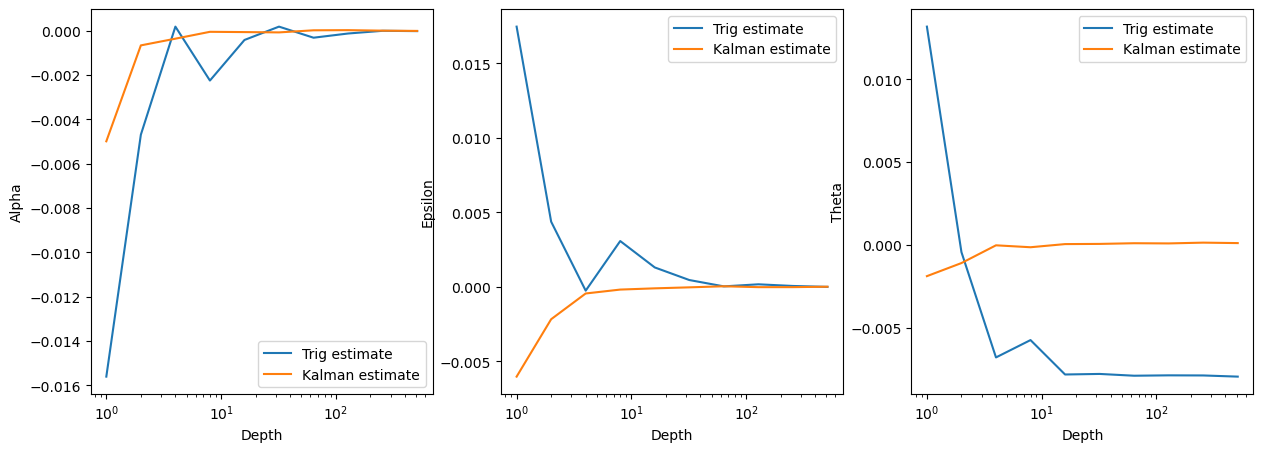

In [107]:
# plot the boostrapped variance
def plot_bootstrapped_variance(depths, trig_estimates, kalman_estimates):
    """Plot the variance of the bootstrapped estimates."""
    trig_variance = [calculate_bootstrapped_variance(trig_estimates[:, idx], xerror_true) for idx in range(len(depths))]
    kalman_variance = [calculate_bootstrapped_variance(kalman_estimates[:, idx], xerror_true) for idx in range(len(depths))]
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for idx, ax in enumerate(axs):
        ax.semilogx(depths, [tv[idx] for tv in trig_variance], label='Trig estimate')
        ax.semilogx(depths, [kv[idx] for kv in kalman_variance], label='Kalman estimate')
        ax.set_xlabel('Depth')
        ax.set_ylabel(['Alpha', 'Epsilon', 'Theta'][idx])
        ax.legend()
        
def plot_boostrapped_bias(depths, trig_estimates, kalman_estimates):
    """Plot the bias of the bootstrapped estimates."""
    trig_bias = [calculate_bootstrapped_bias(trig_estimates[:, idx], xerror_true) for idx in range(len(depths))]
    kalman_bias = [calculate_bootstrapped_bias(kalman_estimates[:, idx], xerror_true) for idx in range(len(depths))]
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for idx, ax in enumerate(axs):
        ax.semilogx(depths, [tv[idx] for tv in trig_bias], label='Trig estimate')
        ax.semilogx(depths, [kv[idx] for kv in kalman_bias], label='Kalman estimate')
        ax.set_xlabel('Depth')
        ax.set_ylabel(['Alpha', 'Epsilon', 'Theta'][idx])
        ax.legend()
plot_bootstrapped_variance(depths, bootstrapped_trig_estimates, bootstrapped_ukf_estimates)
plot_boostrapped_bias(depths, bootstrapped_trig_estimates, bootstrapped_ukf_estimates)


# Experiment 4

Drift at timescale shorter than an experiment 

The strategy is to sample each circuit in an experiment to form a batch. The parameters get a Gaussian random kick after each shot. Each data frame represents a single shot from each circuit. Then, we form an AR model of the shot data with different windows. These are fed into a Kalman filter that estimates the parameters

Next numeric experiment:

simulate an entire experiment with gaussian drift in the parameters. Run a windowed kalman filter on the batches, then simulate taking a stream of data at the longest depth (after that, find the optimal depth by learning the T1 and T2 rates)

In [81]:
def sample_circuit(circ, xstate, gate_depolarization, spam_depolarization):
    model = _krpe.make_pygsti_model(xstate, gate_depolarization, spam_depolarization)
    p1 = model.probabilities(circ)['1']
    return np.random.binomial(1, p1)

def kick_xstate(xstate, Q):
    w = np.random.multivariate_normal(np.zeros(3), Q)
    return xstate + w

def simulate_experiment_1_shot_per_circ(circ_list, xstate, Q, gate_depolarization, spam_depolarization):
    counts = {c : {'0':0, '1':0} for c in circ_list}
    xstate_itr = xstate.copy()
    xhistory = []
    for c in circ_list:
        if sample_circuit(c, xstate, gate_depolarization, spam_depolarization):
            counts[c]['1'] += 1
        else:  
            counts[c]['0'] += 1
        xstate_itr = kick_xstate(xstate_itr, Q)
        xhistory.append(xstate_itr)
    return counts, xhistory

def make_batch_timeseries(circ_list, xstate, Q, num_experiments, gate_depolarization, spam_depolarization):
    timeseries = []
    xhistory = [xstate]
    xstate_itr = xstate.copy()
    for _ in tqdm(range(num_experiments)):
        # note the kicking is done in the simulate_experiment function
        counts, xhistory_experiment = simulate_experiment_1_shot_per_circ(circ_list, xstate_itr, Q, gate_depolarization, spam_depolarization)
        timeseries.append(counts)
        xhistory += xhistory_experiment
    return timeseries, xhistory

In [82]:
def simulate_full_experiment_timeseries(xtrue, Q, depths, gate_depolarization, spam_depolarization, num_shots_per_batch):
    x_trajectory = [xtrue]
    timeseries = []
    dataframe_depths = []
    for d in tqdm(depths):
        circs = _krpe.make_ordered_circuit_list(d)
        for _ in range(num_shots_per_batch):
            xstate = x_trajectory[-1]
            dataframe, xhistory_batch = simulate_experiment_1_shot_per_circ(circs, xstate, Q, gate_depolarization, spam_depolarization)
            timeseries.append(dataframe)
            x_trajectory += xhistory_batch
            dataframe_depths.append(d)
    return timeseries, x_trajectory, dataframe_depths

In [83]:
def plot_trajectory(x_trajectory, true_xstate):
    x_trajectory = np.array(x_trajectory)
    fig, axs = plt.subplots(3, 1, figsize=(15, 15))
    for idx, ax in enumerate(axs):
        ax.plot(x_trajectory[:, idx])
        ax.plot([true_xstate[idx]]*len(x_trajectory), linestyle='dashed')
        ax.set_xlabel('Time')
        ax.set_ylabel(['Alpha', 'Epsilon', 'Theta'][idx])

In [84]:
def collapse_experiment_timeseries(timeseries, interval=None):
    collapsed_out = {}
    if interval is None:
        interval = [0, len(timeseries)]
    for idx in range(interval[0], interval[1]):
        dataframe = timeseries[idx]
        for circ in dataframe.keys():
            if circ in collapsed_out:
                for outcome in dataframe[circ].keys():
                    collapsed_out[circ][outcome] += dataframe[circ][outcome]
            else:
                collapsed_out[circ] = dataframe[circ].copy()
    return collapsed_out

In [85]:
xtrue_start = np.array([0.02, -0.015, 0.003])
depths = [1, 2, 8, 16, 32, 64]
gate_depolarization = 0.000
spam_depolarization = 0.000
num_shots_per_batch = 1000
Q = np.diag([1e-7, 1e-7, 1e-7])
timeseries, x_trajectory, dataframe_depths = simulate_full_experiment_timeseries(xtrue_start, Q, depths, gate_depolarization, spam_depolarization, num_shots_per_batch)

100%|██████████| 6/6 [01:48<00:00, 18.15s/it]


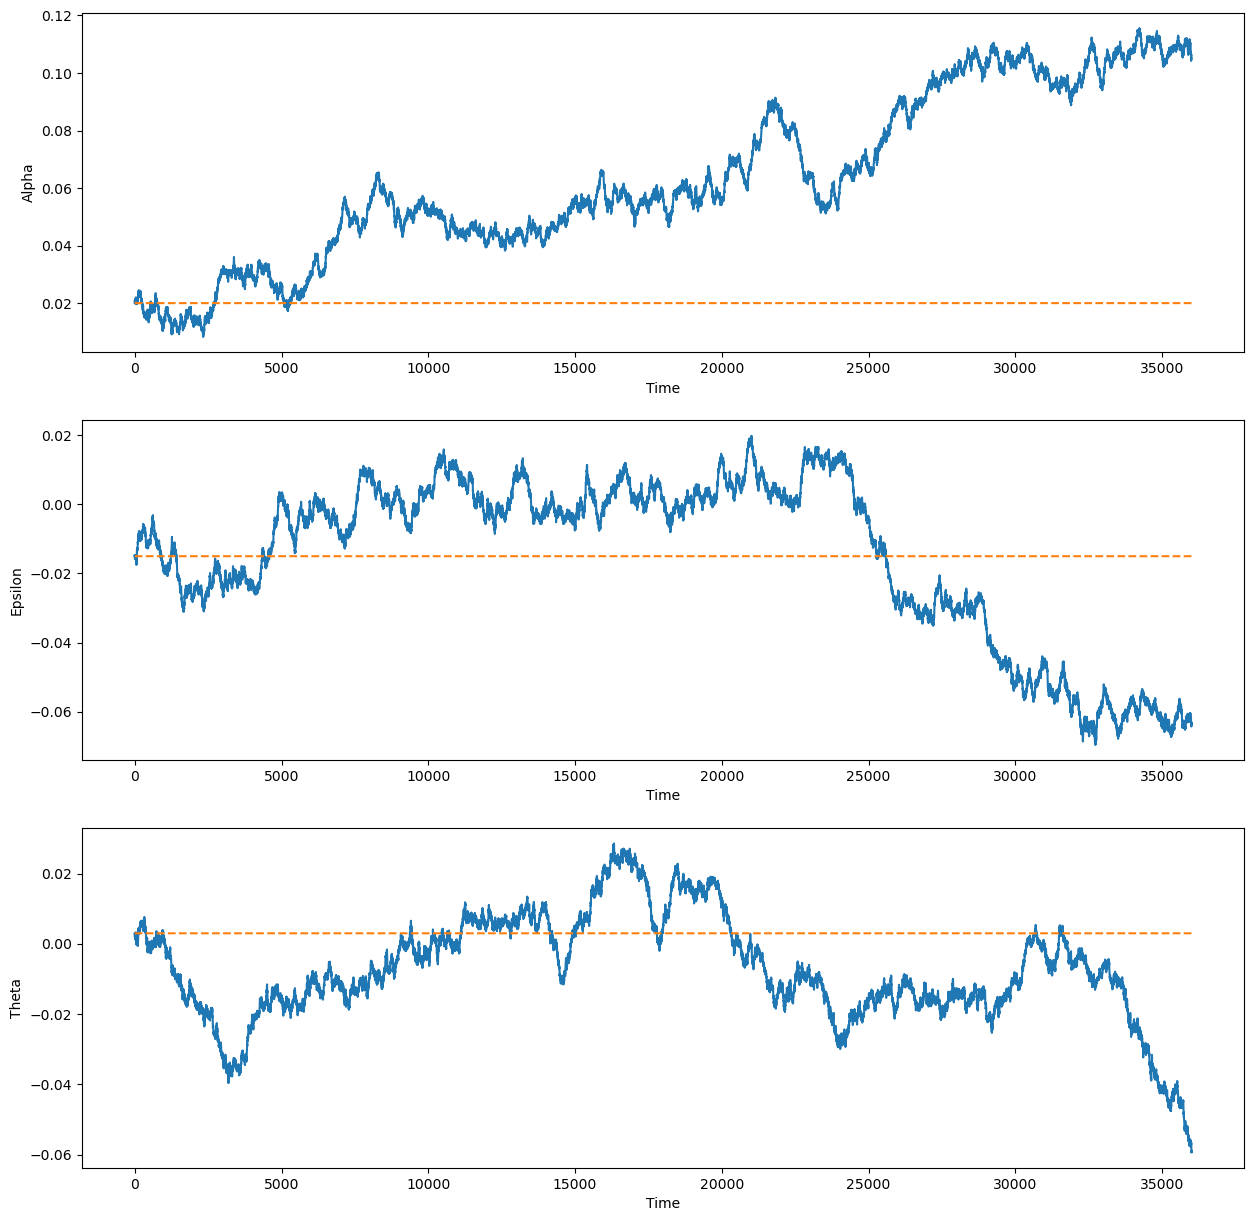

In [86]:
plot_trajectory(x_trajectory, xtrue_start)

In [87]:
collapsed_timeseries = collapse_experiment_timeseries(timeseries)

In [88]:
# trig_inversion

trig_history = [np.array([0, 0, 0])]
trig_error_bound_history = [np.array([1, 1, 1])]
last_good_gen_history = [0]


# make a new trig estimate for each depth
for idx in tqdm(range(len(depths))):
    trig_estimate, trig_error_bound, last_good_gen = _krpe.make_rpe_estimate(collapsed_timeseries, depths[:idx+1])
    trig_history.append(trig_estimate)
    trig_error_bound_history.append(trig_error_bound)
    last_good_gen_history.append(last_good_gen)


100%|██████████| 6/6 [00:00<00:00, 286.03it/s]


In [89]:
mle_estimate, mle_history = _krpe.make_mle_estimate(xtrue, collapsed_timeseries, depths, gate_depolarization, spam_depolarization, show_progress=True)

100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


In [90]:
all_cr_bounds = [[1, 1, 1]] + [_krpe.make_cr_bounds(xtrue, collapsed_timeseries, _krpe.make_rpe_circuits(depths[:i+1]), 0.000, 0.000) for i in range(len(depths))]
cr_bounds = np.array(all_cr_bounds)

In [91]:
def plot_timeseries_estimate_trajectories(xtrue_traj, 
                                          kalman_estimate_traj, kalman_covar_traj, kalman_spacing, 
                                          trig_estimate_traj, trig_error_bound_traj, trig_spacing,
                                          mle_estimate_traj, cr_bounds, mle_spacing, y_lim=0.1):
    fig, axs = plt.subplots(3, 1, figsize=(15, 15))
    for idx, ax in enumerate(axs):
        ax.plot(xtrue_traj[:, idx], label='True value', color='blue')
        ax.set_xlabel('Time')
        ax.set_ylabel(['Alpha', 'Epsilon', 'Theta'][idx])
        ax.legend()
        estimate_spacing = kalman_spacing
        estimate_line = [estimate_spacing*idx for idx in range(len(kalman_estimate_traj))]
        ax.plot(estimate_line, kalman_estimate_traj[:, idx], label='UKF estimate', color='red')
        ax.fill_between(estimate_line, kalman_estimate_traj[:, idx] - 2*np.sqrt(kalman_covar_traj[:, idx, idx]), kalman_estimate_traj[:, idx] + 2*np.sqrt(kalman_covar_traj[:, idx, idx]), alpha=0.5, color='red')
        ax.legend()
        estimate_spacing = trig_spacing
        estimate_line = [estimate_spacing*idx for idx in range(len(trig_estimate_traj))]
        ax.plot(estimate_line, trig_estimate_traj[:, idx], label='Trig estimate', color='green')
        ax.fill_between(estimate_line, trig_estimate_traj[:, idx] - trig_error_bound_traj[:, idx], trig_estimate_traj[:, idx] + trig_error_bound_traj[:, idx], alpha=0.5, color='green')
        ax.legend()
        estimate_spacing = mle_spacing
        estimate_line = [estimate_spacing*idx for idx in range(len(mle_estimate_traj))]
        ax.plot(estimate_line, mle_estimate_traj[:, idx], label='MLE estimate', color='orange')
        ax.fill_between(estimate_line, mle_estimate_traj[:, idx] - cr_bounds[:, idx], mle_estimate_traj[:, idx] + cr_bounds[:, idx], alpha=0.5, color='orange')
        ax.legend()
        ax.set_ylim(xtrue_traj[0, idx]-y_lim, xtrue_traj[0, idx]+y_lim)

In [92]:
# run a Kalman filter
# make the initial estimate based on the depth-1 trig inversion 
num_experiments_per_update = 1

xinitial = np.array(trig_history[1])
Pinitial = np.eye(num_params)
xhistory = [xinitial]
Phistory = [Pinitial]

ukf = _filters.MyUKF(num_params, num_circs)
ukf.x = xinitial
ukf.P = Pinitial
ukf.Q = num_experiments_per_update*Q
for idx in tqdm(range(int(len(timeseries)/num_experiments_per_update))):
    timeseries_interval = [idx*num_experiments_per_update, (idx+1)*num_experiments_per_update]
    d = dataframe_depths[timeseries_interval[0]]
    # assert that the depths are the same for the whole interval
    assert all([d == dataframe_depths[i] for i in range(timeseries_interval[0], timeseries_interval[1])])
    dataset = collapse_experiment_timeseries(timeseries, timeseries_interval)
    num_shots = num_experiments_per_update
    xhistory_update, Phistory_update = ukf.update_from_dataset(dataset, [d], num_shots, save_history=True)
    xhistory += xhistory_update
    Phistory += Phistory_update


xhistory = np.array(xhistory)
Phistory = np.array(Phistory)
trig_history = np.array(trig_history)
trig_error_bound_history = np.array(trig_error_bound_history)
last_good_gen_history = np.array(last_good_gen_history)


100%|██████████| 6000/6000 [04:12<00:00, 23.72it/s]


In [94]:
last_good_gen_history

array([0, 0, 1, 2, 3, 3, 3])

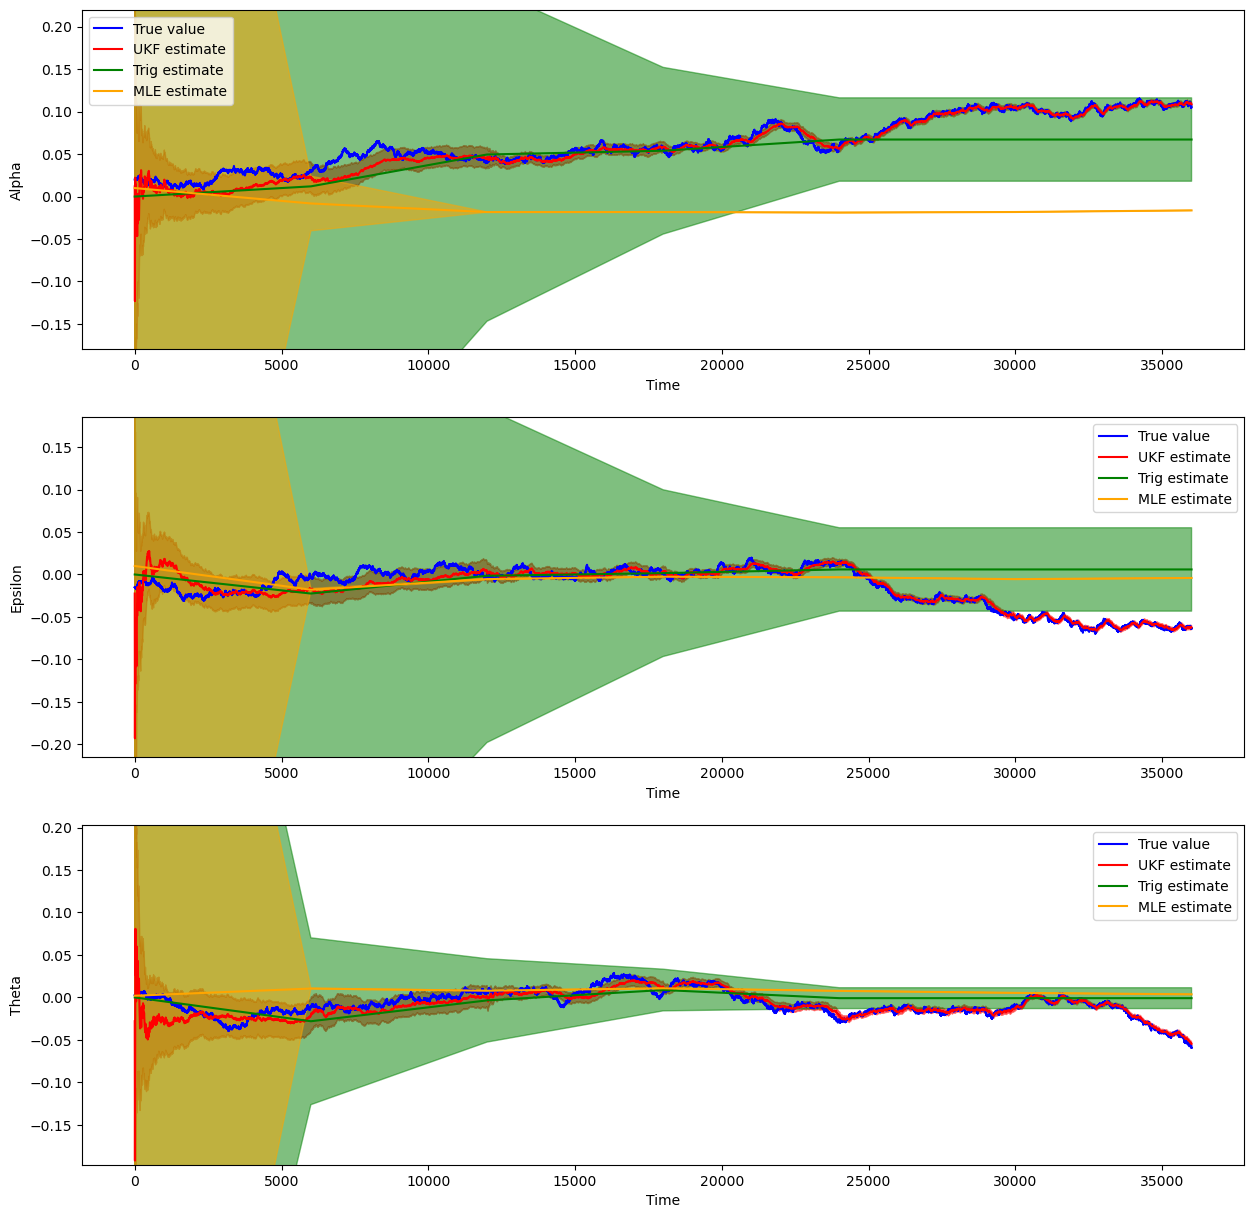

In [93]:
x_trajectory = np.array(x_trajectory)
xhistory = np.array(xhistory)
Phistory = np.array(Phistory)
trig_history = np.array(trig_history)
trig_error_bound_history = np.array(trig_error_bound_history)
last_good_gen_history = np.array(last_good_gen_history)
mle_history = np.array(mle_history)
estimate_spacing = num_shots_per_batch*6
kalman_spacing = num_experiments_per_update*6
ylim = 0.2
plot_timeseries_estimate_trajectories(x_trajectory, xhistory, Phistory, kalman_spacing, trig_history, trig_error_bound_history, estimate_spacing, mle_history, cr_bounds, estimate_spacing, ylim)

## Comparing multiple experiments with different Q's and differenet depths

Now, I'm making the state evolution timeseries first, then observing different experiments, and finally doing Kalman estimation

In [45]:
def make_xstate_timeseries(xstate, Q, time_length):
    xstate_history = [xstate]
    for _ in range(time_length-1):
        xstate = kick_xstate(xstate, Q)
        xstate_history.append(xstate)
    return xstate_history

def sample_from_xstate_timeseries(xstate_timeseries, circs, gate_depolarization, spam_depolarization):
    experiment_timeseries = []
    assert len(xstate_timeseries) == len(circs), print(len(xstate_timeseries), len(circs))
    for xstate, circ in tqdm(zip(xstate_timeseries, circs)):
        samples = {}
        p1 = _krpe.make_pygsti_model(xstate, gate_depolarization, spam_depolarization).probabilities(circ)['1']
        c1 = np.random.binomial(1, p1)
        if c1: 
            samples[circ] = {'0': 0, '1': 1}
        else:
            samples[circ] = {'0': 1, '1': 0}
        experiment_timeseries.append(samples)
    return experiment_timeseries

def dataframe_from_timeseries(timeseries, interval=None):
    dataframe = {}
    if interval is None:
        interval = [0, len(timeseries)]
    for idx in range(interval[0], interval[1]):
        circ = list(timeseries[idx].keys())[0]
        assert len(timeseries[idx]) == 1
        if circ not in dataframe:
            dataframe[circ] = timeseries[idx][circ].copy()
        else:
            for outcome in timeseries[idx][circ].keys():
                dataframe[circ][outcome] += timeseries[idx][circ][outcome]
    return dataframe

In [68]:
def make_kalman_dataframes_from_timeseries(timeseries, num_samples_per_batch):
    assert (len(timeseries)/num_samples_per_batch) % 6 == 0
    kalman_dataframes = []
    num_batches = int(len(timeseries)/(6*num_samples_per_batch))
    for idx in range(num_batches):
        timeseries_interval = [idx*6*num_samples_per_batch, (idx+1)*6*num_samples_per_batch]
        dataframe = dataframe_from_timeseries(timeseries, timeseries_interval)
        kalman_dataframes.append(dataframe)
    return kalman_dataframes

def make_kalman_trajectory(xinitial, pinitial, Q, dataframes, depth, num_samples_per_batch):
    ukf = _filters.MyUKF(3, 6)
    ukf.x = xinitial
    ukf.P = pinitial
    ukf.Q = Q
    xhistory = []
    Phistory = []
    for idx, dataframe in enumerate(dataframes):
        ukf.update_from_dataset(dataframe, [depth], num_samples_per_batch)
        xhistory.append(ukf.x)
        Phistory.append(ukf.P)
    return xhistory, Phistory

In [73]:
time_length/6

100.0

In [74]:
len(xstate_timeseries)

600

In [76]:
len(_krpe.make_ordered_circuit_list(6)*100)

600

In [79]:
xtrue_state = np.array([0.02, -0.015, 0.003])
Q = np.diag([1e-7, 1e-7, 1e-7])
time_length = 600
xstate_timeseries = make_xstate_timeseries(xtrue_state, Q, time_length)
num_samples_per_batch = 1

depths = [1, 2, 4]
kalman_trajs = {}
gate_depolarization = 0.0
spam_depolarization = 0.0
num_samples_per_batch = 10
Pinitial = 0.01*np.eye(3)
xinitial = np.random.multivariate_normal(xtrue_state, P)
for d in depths:
    circs = _krpe.make_ordered_circuit_list(d)*int(time_length/6)
    experiment_timeseries = sample_from_xstate_timeseries(xstate_timeseries, circs, gate_depolarization, spam_depolarization)
    kalman_dataframes = make_kalman_dataframes_from_timeseries(experiment_timeseries, num_samples_per_batch)
    xhistory, Phistory = make_kalman_trajectory(xinitial, Pinitial, Q, kalman_dataframes, d, num_samples_per_batch)
    kalman_trajs[d] = (xhistory, Phistory)


    

600it [00:02, 298.36it/s]
600it [00:01, 342.98it/s]
600it [00:01, 340.88it/s]


In [62]:
num_shots_per_window = 1
dataframes = make_kalman_dataframes_from_timeseries(experiment_timeseries, num_shots_per_window)

P = Q 
xinitial = np.random.multivariate_normal(xtrue_state, P)
ukf = _filters.MyUKF(3, 6)
ukf.x = xinitial
ukf.P = P
ukf.Q = 6*num_shots_per_window*Q
xhistory = []
Phistory = []

for df in tqdm(dataframes):
    ukf.predict()
    ukf.update_from_dataset(df, [d], num_shots_per_window)
    xhistory.append(ukf.x)
    Phistory.append(ukf.P)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:11<00:00, 17.19it/s]


In [63]:
def format_ukf_estimate_trajectory(xhistory, num_shots_per_window):
    # make a piecewise constant estimate trajectory
    estimate_spacing = 6*num_shots_per_window
    estimate_trajectory = []
    for idx, x in enumerate(xhistory):
        estimate_trajectory += [x]*estimate_spacing
    return np.array(estimate_trajectory)

def format_ukf_error_bars(Phistory, num_shots_per_window):
    # the error bars are the sqrt of the diagonal of each P 
    # a piecewise constant like in the estimate trajectory format
    estimate_spacing = 6*num_shots_per_window
    error_bar_history = []
    for idx, P in enumerate(Phistory):
        error_regions = 2*np.sqrt(np.diag(P))
        error_bar_history += [error_regions]*estimate_spacing
    return np.array(error_bar_history)
        
    

In [64]:
def plot_trajectories(trajectories, uncertainty_regions, labels):
    fig, axs = plt.subplots(3, 1, figsize=(15, 15))
    for idx, ax in enumerate(axs):
        for traj, unc, label in zip(trajectories, uncertainty_regions, labels):
            ax.plot(traj[:, idx], label=label)
            if unc is not None:
                ax.fill_between(np.arange(len(traj)), traj[:, idx] - unc[:,idx], traj[:, idx] + unc[:,idx], alpha=0.5)
        ax.set_xlabel('Time')
        ax.set_ylabel(['Alpha', 'Epsilon', 'Theta'][idx])
        ax.legend()
    

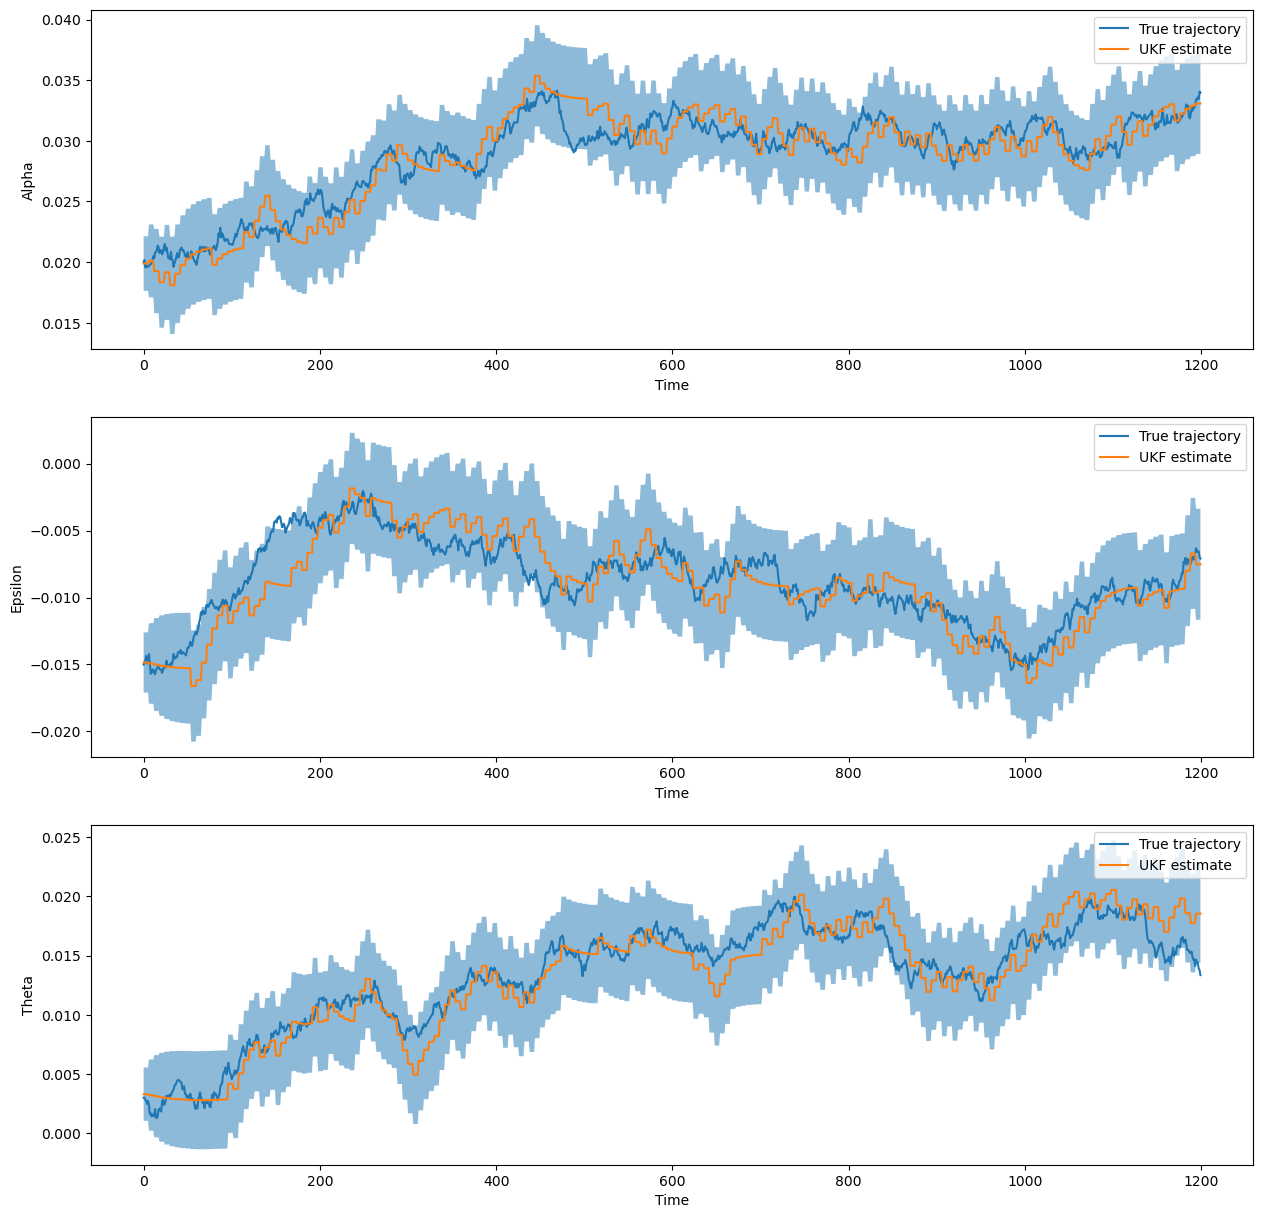

In [65]:
xtrue_trajectory = np.array(xstate_timeseries)
kalman_estimate_trajectory = format_ukf_estimate_trajectory(xhistory, num_shots_per_window)
kalman_error_bars = format_ukf_error_bars(Phistory, num_shots_per_window)

plot_trajectories([xtrue_trajectory, kalman_estimate_trajectory], [None, kalman_error_bars],  ['True trajectory', 'UKF estimate'])

In [163]:
# make a trajectory, then sample from it at different depths, then run Kalman filters on the samples
xtrue_start = np.random.normal(0, 0.01, 3)
print(xtrue_start)
Q = np.diag([1e-6, 1e-6, 1e-6])
time_length = 1200
xstate_timeseries = make_xstate_timeseries(xtrue_start, Q, time_length)
depths = [1, 2, 4, 8, 16, 32, 64]
gate_depolarization = 0.00
spam_depolarization = 0.00
experiments_at_depths = {d : }

[ 0.00724915 -0.01115512  0.01458627]


In [ ]:
def collapse_timeseries(timeseries):
    agregated = {c : 0 for c in timeseries[0].keys()}
    for t in timeseries:
        for c in t.keys():
            agregated[c] += t[c]
    return agregated

In [ ]:
def make_ordered_circuit_list(d):
    x_cos_circ = _krpe.make_x_cos_circuit(d)
    x_sin_circ = _krpe.make_x_sin_circuit(d)
    z_cos_circ = _krpe.make_z_cos_circuit(d)
    z_sin_circ = _krpe.make_z_sin_circuit(d)
    interleaved_cos_circ = _krpe.make_interleaved_cos_circuit(d)
    interleaved_sin_circ = _krpe.make_interleaved_sin_circuit(d)
    return [x_cos_circ, x_sin_circ, z_cos_circ, z_sin_circ, interleaved_cos_circ, interleaved_sin_circ]


def make_ar_prob_estimate(timeseries, circuit_ordering, last_idx, window_size, forgetting_constant):
    normalization = 1/sum([forgetting_constant**i for i in range(window_size)])
    prob_estimate = np.zeros(len(circuit_ordering))
    assert last_idx >= window_size
    for i in range(window_size):
        shot_data_frame_i = timeseries[last_idx - i]
        shot_vec_i = np.array([shot_data_frame_i[c] for c in circuit_ordering])
        prob_estimate += normalization*forgetting_constant**i*shot_vec_i
    return prob_estimate

In [ ]:
# make a list of experiemnts with 1 count per circuit
depths = [32]
circs = _krpe.make_rpe_circuits(depths)
xstate = [0.02, -0.015, 0.003]
Q = np.diag([1e-6, 1e-6, 1e-8])
num_batches = 100
gate_depolarization = 0.00
spam_depolarization = 0.00
timeseries = [{c : 1 for c in circs} for _ in range(num_batches)]
print("ar prob estimate: ", make_ar_prob_estimate(timeseries, circs, 11, 10, 0.9))

ar prob estimate:  [1. 1. 1. 1. 1. 1.]


In [ ]:
# make a batch of timeseries
depths = [32]
circs = _krpe.make_rpe_circuits(depths)
xstate = [0.02, -0.015, 0.003]
Q = np.diag([1e-6, 1e-6, 1e-8])
num_batches = 100
gate_depolarization = 0.00
spam_depolarization = 0.00
timeseries, xhistory = make_batch_timeseries(circs, xstate, Q, num_batches, gate_depolarization, spam_depolarization)

100%|██████████| 100/100 [00:02<00:00, 47.01it/s]


In [ ]:
timeseries[100-10]

{Circuit(Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gxpi

In [ ]:
print("ar prob estimate: ", make_ar_prob_estimate(timeseries, circs, 99, 10, 0.9))

ar prob estimate:  [0.77369278 0.05948221 0.12436253 0.         1.         0.67797466]


In [ ]:
def estimate_from_window(ukf, timeseries, d, last_idx, window_size, forgetting_constant):
    circs = make_ordered_circuit_list(d)
    prob_estimate = make_ar_prob_estimate(timeseries, circs, last_idx, window_size, forgetting_constant)
    ukf.predict()
    print(prob_estimate, d, window_size)
    ukf.update(prob_estimate, d, window_size)
    return ukf

In [ ]:
xtrue_start = np.array([0.02, -0.015, 0.003])
Q = np.diag([1e-10, 1e-10, 1e-12])
d = 8
circs = make_ordered_circuit_list(d)

num_batches = 1000
gate_depolarization = 0.00
spam_depolarization = 0.00
timeseries, true_xhistory = make_batch_timeseries(circs, xtrue_start, Q, num_batches, gate_depolarization, spam_depolarization)

100%|██████████| 1000/1000 [00:19<00:00, 51.81it/s]


In [ ]:
P0 = 1e-10*np.eye(3)
x0 = xtrue_start.copy()


num_windows = 400
window_size = 200
initial_idx = window_size
x0 = true_xhistory[initial_idx]

forgetting_constant = 0.99
xhistory = [x0]
Phistory = [P0]
index_history = [initial_idx]

ukf = _filters.MyUKF(3, 6)
ukf.x = x0
ukf.P = P0
ukf.Q = np.diag([1e-10, 1e-10, 1e-12])

for i in tqdm(range(num_windows)):
    prob_estimate = make_ar_prob_estimate(timeseries, circs, initial_idx + i, window_size, forgetting_constant)
    ukf.predict()
    ukf.update(prob_estimate, d, window_size)
    xhistory.append(ukf.x)
    Phistory.append(ukf.P)
    index_history.append(initial_idx + i)

100%|██████████| 400/400 [00:16<00:00, 24.74it/s]


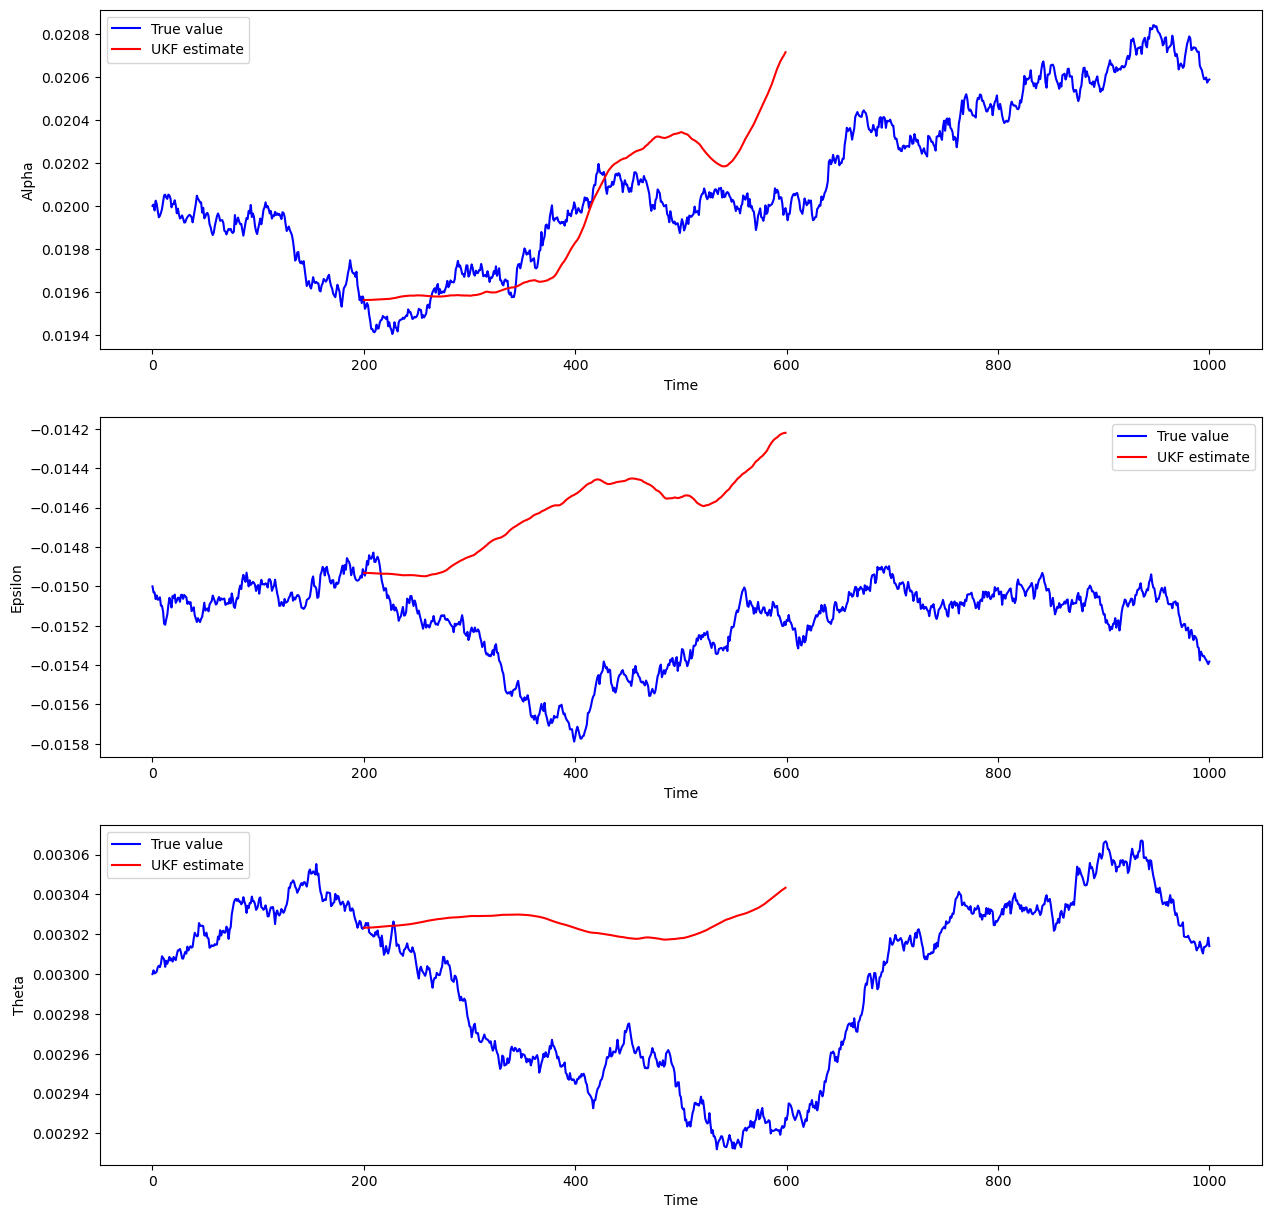

In [ ]:
# plot the ukf estimate trajectory on top of the true trajectory, where the ukf history is spaced out to match the true history
ukf_xhistory = np.array(xhistory)
true_xhistory = np.array(true_xhistory)
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
for idx, ax in enumerate(axs):
    ax.plot(true_xhistory[:, idx], label='True value', color='blue')
    ax.set_xlabel('Time')
    ax.set_ylabel(['Alpha', 'Epsilon', 'Theta'][idx])
    ax.legend()
    ax.plot(index_history, ukf_xhistory[:, idx], label='UKF estimate', color='red')
    ax.legend()
# ukf_xhistory = np.array(ukf_xhistory)
# true_xhistory = np.array(true_xhistory)
# fig, axs = plt.subplots(3, 1, figsize=(15, 15))
# for idx, ax in enumerate(axs):
#     ax.plot(true_xhistory[:, idx], label='True value', color='blue')
#     ax.set_xlabel('Time')
#     ax.set_ylabel(['Alpha', 'Epsilon', 'Theta'][idx])
#     ax.legend()
#     estimate_spacing = 6*num_shots_per_batch
#     estimate_line = [estimate_spacing*idx for idx in range(len(ukf_xhistory))]
#     ax.plot(estimate_line, ukf_xhistory[:, idx], label='UKF estimate', color='red')
#     ax.legend()

In [ ]:
def make_rpe_at_depth(data_dict, d, num_shots_per_circuit):
    # x_cos_circs, x_sin_circs = make_x_sequences(depths)
    # z_cos_circs, z_sin_circs = make_z_sequences(depths)
    # interleaved_cos_circs, inerleaved_sin_circs = make_interleaved_sequences(depths)
    # z_estimates, z_last_good_generation = process_zgate_data(dataset, z_cos_circs, z_sin_circs, depths)
    # x_estimates, x_last_good_generation = process_xgate_data(dataset, x_cos_circs, x_sin_circs, depths)
    # interleaved_estimates, interleaved_last_good_generation = process_interleaved_data(dataset, interleaved_cos_circs, inerleaved_sin_circs, depths)
    # min_last_good_gen = min(z_last_good_generation, x_last_good_generation, interleaved_last_good_generation)
    # alpha, epsilon, theta = make_error_estimate(z_estimates[min_last_good_gen], x_estimates[min_last_good_gen], interleaved_estimates[min_last_good_gen])
    # direct_error_bound = np.pi/(2*4**min_last_good_gen)
    # theta_error_bound = direct_error_bound/(4*np.cos(np.pi*epsilon/2)) # Equation III.11
    # return [alpha, epsilon, theta], [direct_error_bound, theta_error_bound], min_last_good_gen

    x_cos_circ = make_x_cos_circuit(d)
    x_sin_circ = make_x_sin_circuit(d)
    z_cos_circ = make_z_cos_circuit(d)
    z_sin_circ = make_z_sin_circuit(d)
    interleaved_cos_circ = make_interleaved_cos_circuit(d)
    interleaved_sin_circ = make_interleaved_sin_circuit(d)
    x_cos_obs = data_dict[x_cos_circ]/num_shots_per_circuit
    x_sin_obs = data_dict[x_sin_circ]/num_shots_per_circuit
    z_cos_obs = data_dict[z_cos_circ]/num_shots_per_circuit
    z_sin_obs = data_dict[z_sin_circ]/num_shots_per_circuit
    interleaved_cos_obs = data_dict[interleaved_cos_circ]/num_shots_per_circuit
    interleaved_sin_obs = data_dict[interleaved_sin_circ]/num_shots_per_circuit
    prob_quad_x = (1-2*x_cos_obs) + 1j*(1-2*x_sin_obs)
    prob_quad_z = (1-2*z_cos_obs) + 1j*(1-2*z_sin_obs)
    prob_quad_interleaved = (1-2*interleaved_cos_obs) + 1j*(1-2*interleaved_sin_obs)
    phase_estimate_x = -np.angle(prob_quad_x)/8
    phase_estimate_z = -np.angle(prob_quad_z)/8
    return phase_estimate_x, phase_estimate_z


In [ ]:
areg_data = collapse_timeseries(timeseries)
make_rpe_at_depth(areg_data, d, num_shots_per_batch)

NameError: name 'num_shots_per_batch' is not defined

In [ ]:
xfinal = xhistory[-1]

In [ ]:
xfinal

array([ 0.03869206, -0.07608573,  0.00446781])